In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import imageio

In [12]:
X =  np.array([[-4.5,0],[-9,0],[-1,0],[0,1],[2,1],[4,0],[5,1]])
S = np.array([[1],[0.2],[3]])
M =  np.array([[-4,0],[0,0],[8,0]])
P = np.array([[1/3],[1/3],[1/3]])


In [4]:
X =  np.array([[-3],[-2.5],[-1],[0],[2],[4],[5]])
S = np.array([[1],[0.2],[3]])
M =  np.array([[-4],[0],[8]])
P = np.array([[1/3],[1/3],[1/3]])

In [14]:
X =  np.array([[-3],[-2.5],[-1],[0],[2],[4],[5]])
S = np.array([[1],[0.2],[3]])
M =  np.array([[-4],[0],[8]])
P = np.array([[1/3],[1/3],[1/3]])

In [90]:
class EM():
    
    def __init__(self, K):
        self.K = K
    
    def GaussianMixture(self, X, M, S, P , Id ):
        if Id==0:
            S = np.sqrt(S)
            G = []
            for Xn in X:
                G.append([stats.norm(Mk,Sk).pdf(Xn) for Mk,Sk in zip(M,S)] )
            G = np.array(G)[:,:,0]
            return P.T * G
        if Id==1:
            S = np.sqrt(S)
            G = []
            for Xn in X:
                g = []
                for k in range(M.shape[0]):
                    g.append( stats.norm(M[k],S[k]).pdf(Xn)  )
                G.append(g)
            G = np.array(G)[:,:,0]
            return P.T * G
        if Id==2:
            G = np.zeros((X.shape[0], M.shape[0]))
            for k in range(M.shape[0]):
                first_part = 1 / np.sqrt(2 * np.pi * S[k])
                second_part = np.exp(-(1 / (2 * S[k])) * (X - M[k, :]) ** 2)
                G[:, k] = np.prod(first_part * second_part, axis=1)
            return P.T * G
        if Id==3:
            S = np.array([ np.eye(X.shape[1])*Sk for Sk in S])
            G = np.zeros((X.shape[0], M.shape[0]))
            for k in range(M.shape[0]):
                G[:, k] = stats.multivariate_normal(M[k], S[k]).pdf(X)
            return P.T * G        

    def calc_G(self, gaussianMixture ):  # returns an (N x K) array
        G = gaussianMixture
        G = G / np.sum(G , axis=1).reshape(-1,1)
        return G

    def calc_Nk(self, G):   # returns an (1 x K) array
        return np.sum(G , axis=0).reshape(-1,1)

    def calc_Nk2(self, G):   # returns an (1 x K) array
        N = []
        for k in range(G.shape[1]):
            nk = 0
            for n in range(G.shape[0]):
                nk += G[n][k]
            N.append(nk)
        return np.array(N).reshape(-1,1)

    def calc_M(self, X, G, Nk): # returns an (K x D) array
        return G.T.dot(X) / Nk

    def calc_M2(self, X, G, Nk): # returns an (K x D) array
        M = []
        for k in range(G.shape[1]):
            row = 0
            for n in range(X.shape[0]):
                row += G[n][k] * X[n]
            M.append(row)

        return np.array(M)/Nk


    def calc_S2(self, X, G, Nk, M):
        S = []
        for k in range(M.shape[0]):
            row = 0
            for n in range(X.shape[0]):
                for d in range(X.shape[1]):
                    row += G[n][k]*np.square(X[n][d]- M[k][d])
            S.append(row)
        return np.array(S).reshape(-1,1) /(X.shape[1] * Nk )

    def calc_S(self, X, G, Nk, M):
        S = np.ones((M.shape[0],1))
        for k in range(M.shape[0]):
            S[k] = np.sum(np.sum(G[:, k].reshape((-1, 1))*np.square(X- M[k]), axis=1))

        return np.array(S) /(X.shape[1] * Nk )


    def calc_P(self, Nk, N):
        return Nk/N

    def initializeMatrices(self, K):
        M = np.random.uniform(0,1,(K,X.shape[1]))
        S = np.random.uniform(0, 1, (K,1))
        P = np.ones((K,1)) * 1/K
        gaussianMixture = GaussianMixture(X, M, S, P,3)
        return M, S, P, gaussianMixture

    def logLikelihood(self,  mixtureMatrix ):
        return np.sum(np.log(np.sum(mixtureMatrix, axis=1)))

    def getPredictedValues(self):
        return self.M[ self.Gamma.argmax(axis=1) ]

    def getError(self, X ):
        return np.square( np.sum(X-self.Xpred)/X.shape[0] )

    def savePredictedImage(self, shape):
        Xpred = (self.Xpred*255).astype(np.uint8)
        Xpred = Xpred.reshape(shape)
        imageio.imwrite('images\im_K' + str(self.K) + '.jpg' ,Xpred )


    def fit(self, X):
        K = self.K
        M, S, P, gaussianMixture = initializeMatrices(K)
        tol = 1
        iters = 200
        self.logLikelihoods = []
        oldL = logLikelihood(gaussianMixture )

        for i in range(iters):
            if (i%10==0):
                print("Iteration:", i)
            Gamma = calc_G(gaussianMixture)
            Nk = self.calc_Nk(Gamma)
            M = self.calc_M(X, Gamma, Nk)
            S = self.calc_S(X, Gamma, Nk , M)
            P = self.calc_P(Nk,X.shape[0])
            gaussianMixture = self.GaussianMixture(X, M, S, P,3)
            L = self.logLikelihood(gaussianMixture )
            self.logLikelihoods.append(L)

            if (L-oldL<tol ):
                print("Successful")
                break
            elif (L < oldL):
                print("There is a problem!")
                break
            oldL = L
        
        self.Gamma = Gamma
        self.M = M
        self.Xpred = self.getPredictedValues()
        

In [91]:
im = imageio.imread('images\im.jpg')
shape = im.shape
im = im.reshape((im.shape[0]*im.shape[1],3))
X = im/255

In [109]:
%%time
em = EM(10)
em.fit(X)
em.savePredictedImage(shape)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
Successful
CPU times: user 1min 56s, sys: 3.07 s, total: 1min 59s
Wall time: 1min 1s


Text(0, 0.5, 'Log-likelihood')

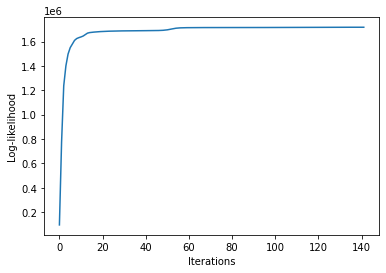

In [115]:
plt.plot( np.arange(len(em.logLikelihoods)),em.logLikelihoods )
plt.xlabel("Iterations")
plt.ylabel("Log-likelihood")